In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

import src.config as config
from src.synthetic_data import SyntheticDataGenerator

In [33]:
# Generate data for 1 week 
gen = SyntheticDataGenerator()

# Generate order data using the same parameters as config.py
df_orders = gen.generate_poisson_events(
    n_days=7,  # 1 week
    base_rate=config.BASE_RATE,  # Base orders per hour
    peak_hours=config.PEAK_HOURS,  # Peak hours during the day
    peak_multiplier=config.PEAK_MULTIPLIER,  # How much busier at peak times
    seed=config.SEED
)

print(f"Generated {len(df_orders)} hours of data")
print(f"Total orders: {df_orders['event_count'].sum()}")
print("First few rows:")
print(df_orders.head(10))
print("Data summary:")
print(df_orders.describe())


Generated 168 hours of data
Total orders: 1419
First few rows:
                   timestamp  event_count  hour
0 2025-11-30 17:44:41.820963           19    17
1 2025-11-30 18:44:41.820972            6    18
2 2025-11-30 19:44:41.820974            8    19
3 2025-11-30 20:44:41.820975            8    20
4 2025-11-30 21:44:41.820975            3    21
5 2025-11-30 22:44:41.820976            9    22
6 2025-11-30 23:44:41.820977           13    23
7 2025-12-01 00:44:41.820978            4     0
8 2025-12-01 01:44:41.820979            8     1
9 2025-12-01 02:44:41.820980            6     2
Data summary:
                           timestamp  event_count        hour
count                            168   168.000000  168.000000
mean   2025-12-04 05:14:41.821029632     8.446429   11.500000
min       2025-11-30 17:44:41.820963     2.000000    0.000000
25%    2025-12-02 11:29:41.821000960     6.000000    5.750000
50%    2025-12-04 05:14:41.821029376     8.000000   11.500000
75%    2025-12-05 22:59

## 2. Data Visualization - 1 Day and 1 Week


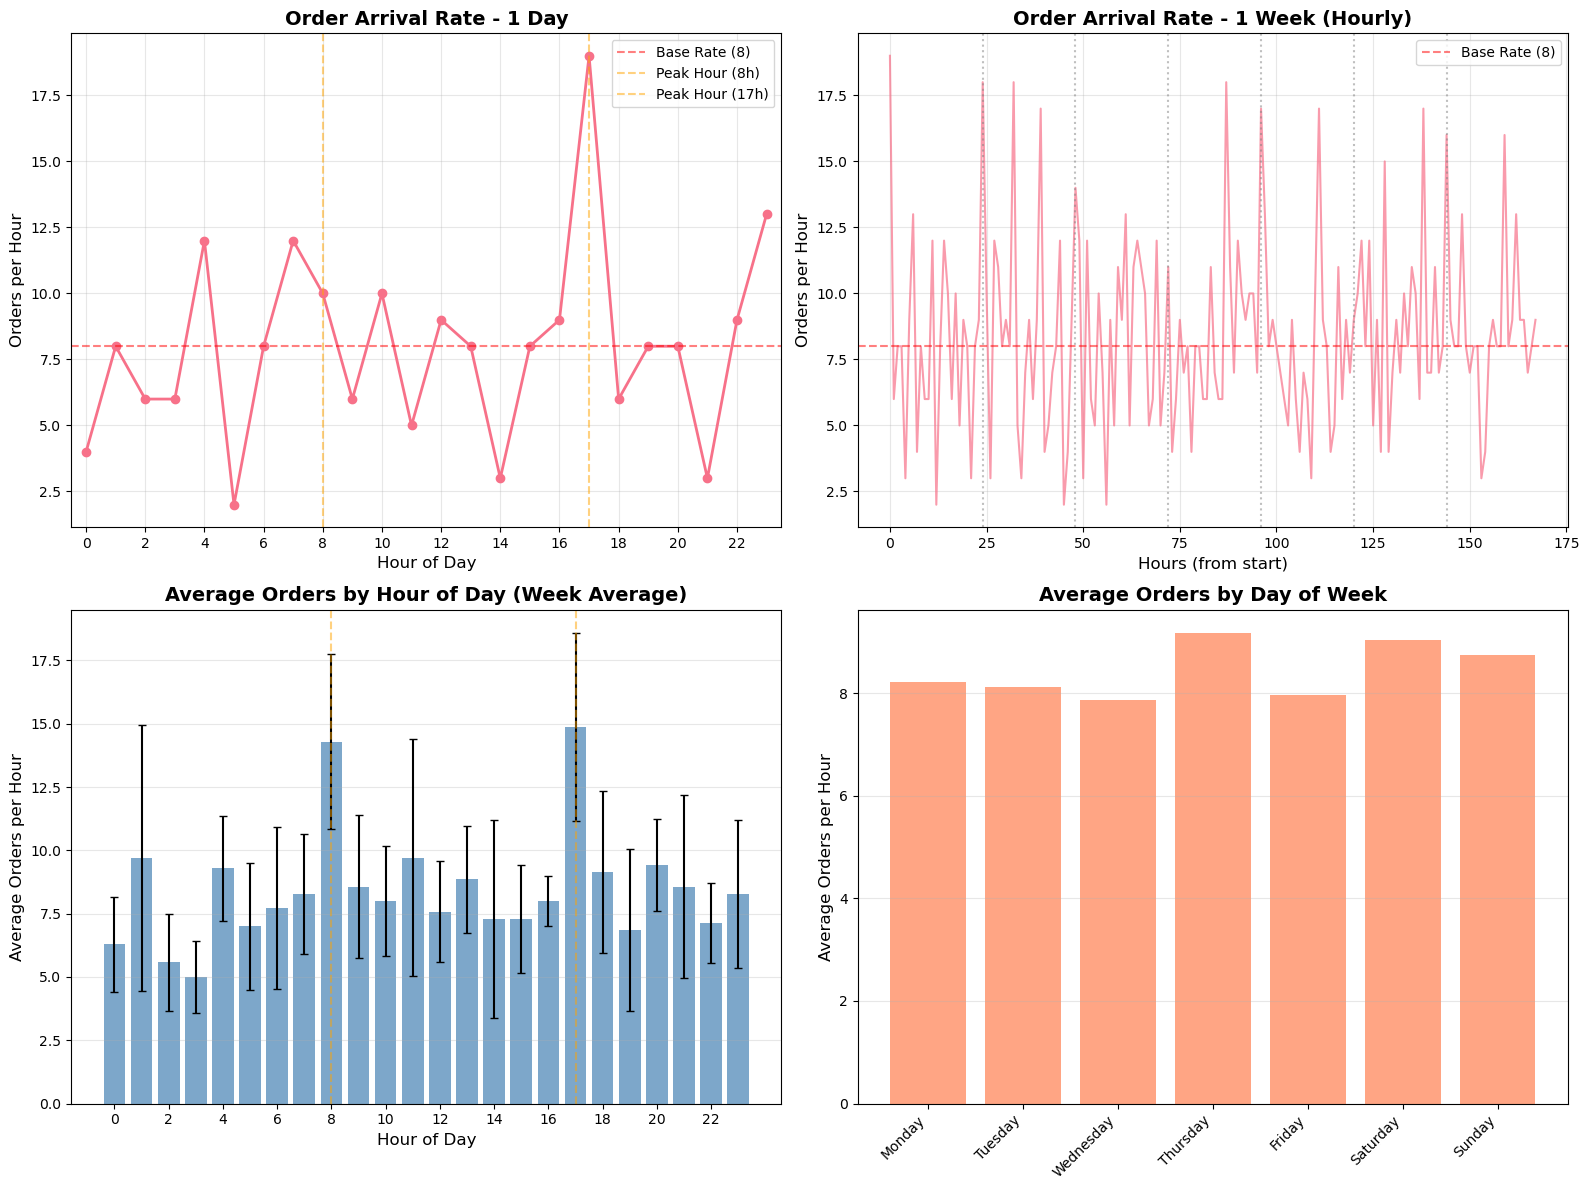

In [34]:
df_orders['hour_of_day'] = df_orders['timestamp'].dt.hour
df_orders['day_of_week'] = df_orders['timestamp'].dt.dayofweek
df_orders['day_name'] = df_orders['timestamp'].dt.day_name()

# Extract first day and full week
df_day = df_orders.iloc[:24].copy()
df_week = df_orders.copy()

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Orders over 1 day
ax1 = axes[0, 0]
# Sort by hour_of_day to prevent line connecting first and last point
df_day_sorted = df_day.sort_values('hour_of_day')
ax1.plot(df_day_sorted['hour_of_day'], df_day_sorted['event_count'], marker='o', linewidth=2, markersize=6)
ax1.axhline(y=config.BASE_RATE, color='r', linestyle='--', alpha=0.5, label=f'Base Rate ({config.BASE_RATE})')
for peak_hour in config.PEAK_HOURS:
    ax1.axvline(x=peak_hour, color='orange', linestyle='--', alpha=0.5, label=f'Peak Hour ({peak_hour}h)')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Orders per Hour', fontsize=12)
ax1.set_title('Order Arrival Rate - 1 Day', fontsize=14, fontweight='bold')
ax1.set_xticks(range(0, 24, 2))
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(-0.5, 23.5)

#Orders over 1 week (hourly)
ax2 = axes[0, 1]
hours_week = np.arange(len(df_week))
ax2.plot(hours_week, df_week['event_count'], linewidth=1.5, alpha=0.7)
ax2.axhline(y=config.BASE_RATE, color='r', linestyle='--', alpha=0.5, label=f'Base Rate ({config.BASE_RATE})')
# Mark day boundaries
for day in range(1, 7):
    ax2.axvline(x=day * 24, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Hours (from start)', fontsize=12)
ax2.set_ylabel('Orders per Hour', fontsize=12)
ax2.set_title('Order Arrival Rate - 1 Week (Hourly)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

#average orders by hour of day 
ax3 = axes[1, 0]
hourly_avg = df_week.groupby('hour_of_day')['event_count'].mean()
hourly_std = df_week.groupby('hour_of_day')['event_count'].std()
ax3.bar(hourly_avg.index, hourly_avg.values, yerr=hourly_std.values, capsize=3, alpha=0.7, color='steelblue')
for peak_hour in config.PEAK_HOURS:
    ax3.axvline(x=peak_hour, color='orange', linestyle='--', alpha=0.5)
ax3.set_xlabel('Hour of Day', fontsize=12)
ax3.set_ylabel('Average Orders per Hour', fontsize=12)
ax3.set_title('Average Orders by Hour of Day (Week Average)', fontsize=14, fontweight='bold')
ax3.set_xticks(range(0, 24, 2))
ax3.grid(True, alpha=0.3, axis='y')

#Orders by day of week
ax4 = axes[1, 1]
daily_avg = df_week.groupby('day_name')['event_count'].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = daily_avg.reindex([d for d in day_order if d in daily_avg.index])
ax4.bar(range(len(daily_avg)), daily_avg.values, alpha=0.7, color='coral')
ax4.set_xticks(range(len(daily_avg)))
ax4.set_xticklabels(daily_avg.index, rotation=45, ha='right')
ax4.set_ylabel('Average Orders per Hour', fontsize=12)
ax4.set_title('Average Orders by Day of Week', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figs/data_exploration_overview.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
df_ml = df_orders.copy()

# Convert time to hours 
df_ml['time_minutes'] = np.arange(len(df_ml)) * 60  # Each row is 1 hour = 60 minutes
df_ml['hour_of_day'] = (df_ml['time_minutes'] / 60.0) % 24
df_ml['day_of_week'] = (df_ml['time_minutes'] // (60 * 24)) % 7

df_ml['prev_hour_count'] = df_ml['event_count'].shift(1)

# Target variable
df_ml['order_count'] = df_ml['event_count']

df_ml = df_ml.dropna().reset_index(drop=True)

print(f"Prepared {len(df_ml)} samples for ML")
print("Feature statistics:")
print(df_ml[['hour_of_day', 'day_of_week', 'prev_hour_count', 'order_count']].describe())
print("First few rows:")
print(df_ml[['hour_of_day', 'day_of_week', 'prev_hour_count', 'order_count']].head(10))


Prepared 167 samples for ML
Feature statistics:
       hour_of_day  day_of_week  prev_hour_count  order_count
count   167.000000   167.000000       167.000000   167.000000
mean     11.568862     3.017964         8.443114     8.383234
std       6.905977     1.998412         3.484224     3.386252
min       0.000000     0.000000         2.000000     2.000000
25%       6.000000     1.000000         6.000000     6.000000
50%      12.000000     3.000000         8.000000     8.000000
75%      17.500000     5.000000        10.000000    10.000000
max      23.000000     6.000000        19.000000    18.000000
First few rows:
   hour_of_day  day_of_week  prev_hour_count  order_count
0          1.0            0             19.0            6
1          2.0            0              6.0            8
2          3.0            0              8.0            8
3          4.0            0              8.0            3
4          5.0            0              3.0            9
5          6.0            0   

In [36]:
# Prepare features and target
feature_cols = ['hour_of_day', 'day_of_week', 'prev_hour_count']
X = df_ml[feature_cols].values
y = df_ml['order_count'].values

#80/10/10 split
n_total = len(X)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:n_train + n_val]
y_val = y[n_train:n_train + n_val]
X_test = X[n_train + n_val:]
y_test = y[n_train + n_val:]

print(f"Total samples: {n_total}")
print(f"Train set: {len(X_train)} ({100*len(X_train)/n_total:.1f}%)")
print(f"Validation set: {len(X_val)} ({100*len(X_val)/n_total:.1f}%)")
print(f"Test set: {len(X_test)} ({100*len(X_test)/n_total:.1f}%)")
print(f"Train target stats: mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"Val target stats: mean={y_val.mean():.2f}, std={y_val.std():.2f}")
print(f"Test target stats: mean={y_test.mean():.2f}, std={y_test.std():.2f}")


Total samples: 167
Train set: 133 (79.6%)
Validation set: 16 (9.6%)
Test set: 18 (10.8%)
Train target stats: mean=8.23, std=3.45
Val target stats: mean=9.62, std=3.14
Test target stats: mean=8.39, std=2.73


In [37]:
baseline_model = RandomForestRegressor(random_state=config.SEED)
baseline_model.fit(X_train, y_train)

def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"{set_name} Set Performance:")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R2: {r2:.3f}")
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'y_pred': y_pred}

train_metrics = evaluate_model(baseline_model, X_train, y_train, "Train")
val_metrics = evaluate_model(baseline_model, X_val, y_val, "Validation")
test_metrics = evaluate_model(baseline_model, X_test, y_test, "Test")

# Feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importances:")
print(feature_importance)


Train Set Performance:
RMSE: 1.354
MAE: 1.079
R2: 0.846
Validation Set Performance:
RMSE: 3.036
MAE: 2.332
R2: 0.065
Test Set Performance:
RMSE: 2.332
MAE: 1.675
R2: 0.271
Feature Importances:
           feature  importance
0      hour_of_day    0.508742
2  prev_hour_count    0.258617
1      day_of_week    0.232641


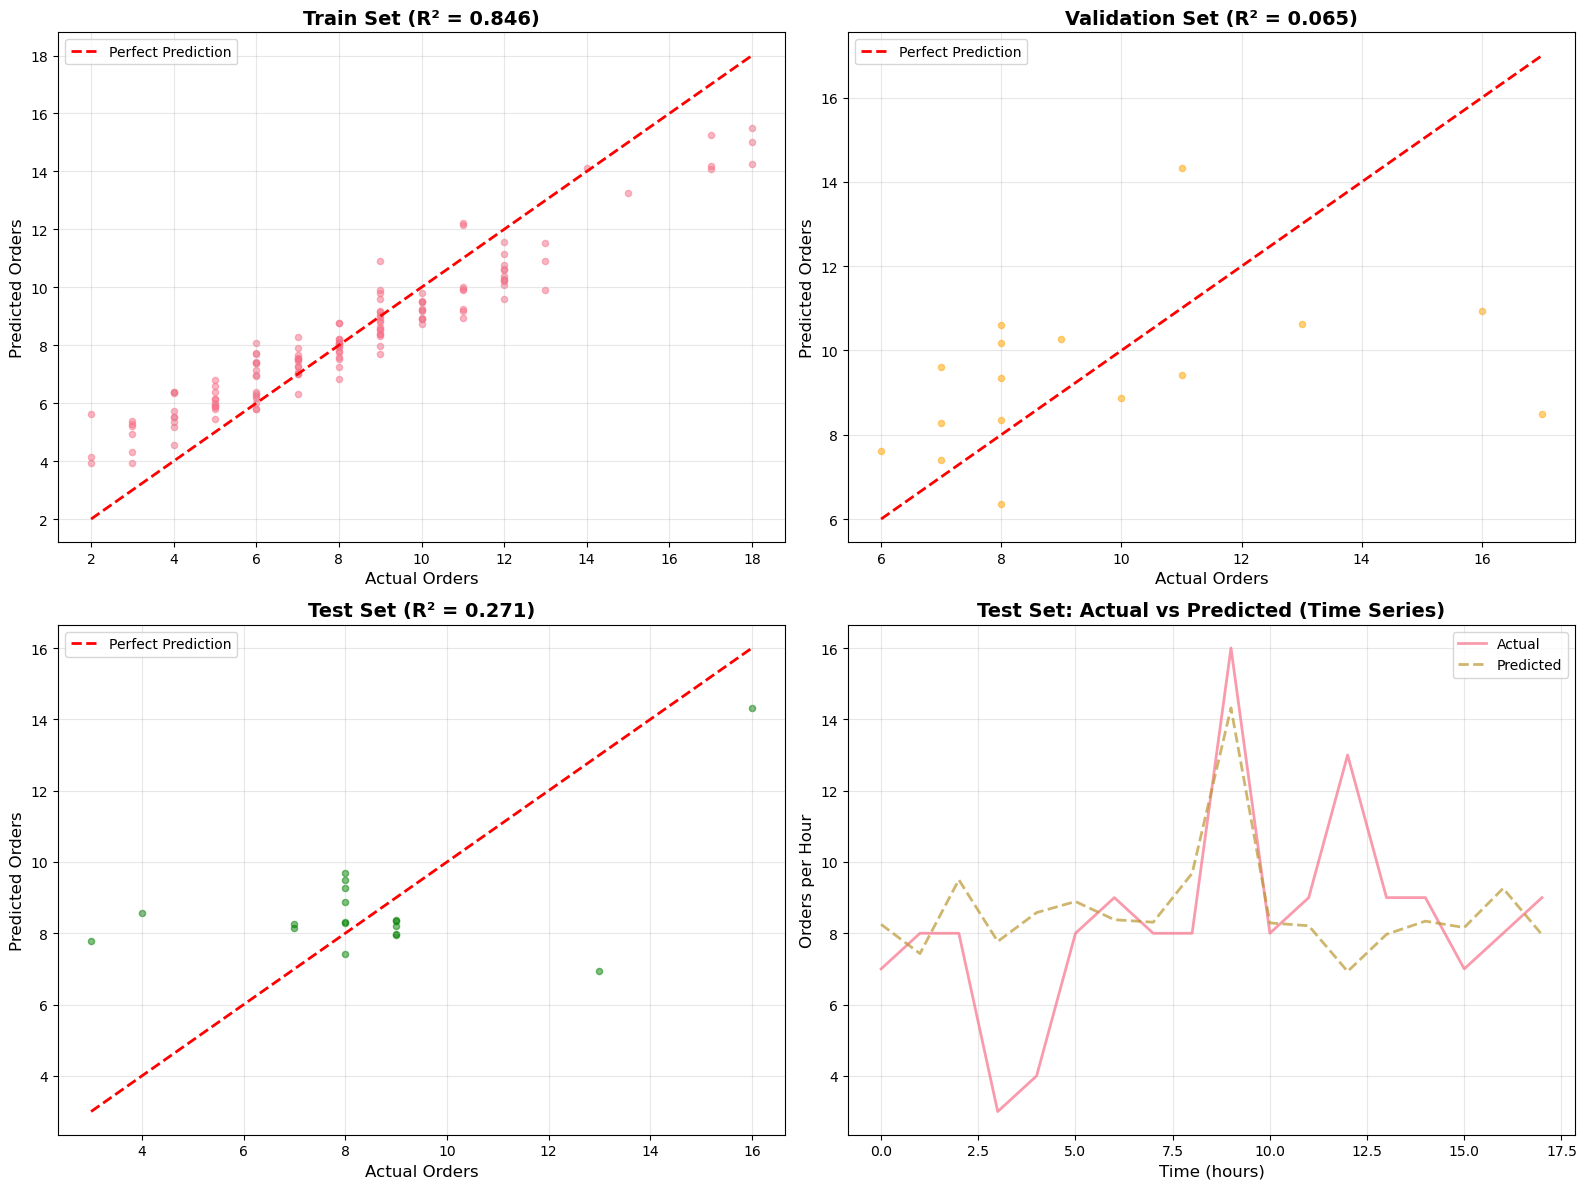

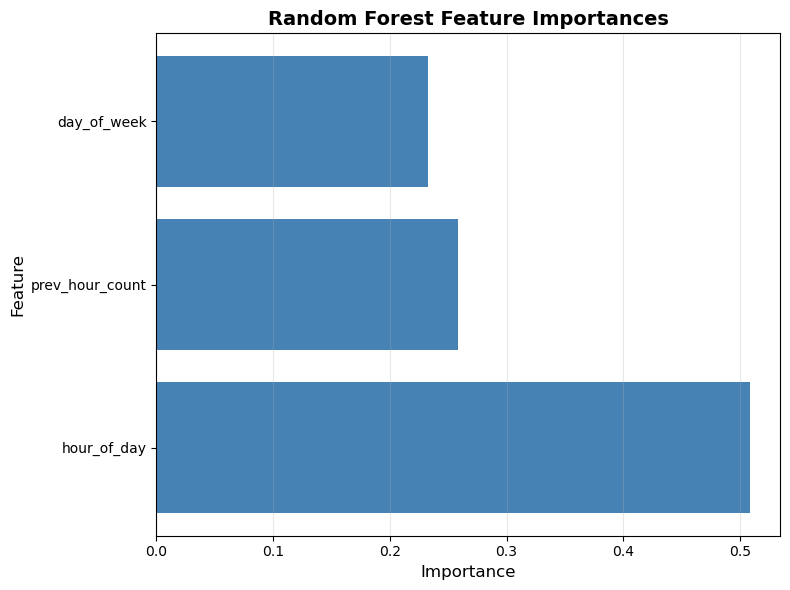

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Pred vs actual  train
ax1 = axes[0, 0]
ax1.scatter(y_train, train_metrics['y_pred'], alpha=0.5, s=20)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Orders', fontsize=12)
ax1.set_ylabel('Predicted Orders', fontsize=12)
ax1.set_title(f'Train Set (R² = {train_metrics["r2"]:.3f})', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Pred vs actual validation
ax2 = axes[0, 1]
ax2.scatter(y_val, val_metrics['y_pred'], alpha=0.5, s=20, color='orange')
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Orders', fontsize=12)
ax2.set_ylabel('Predicted Orders', fontsize=12)
ax2.set_title(f'Validation Set (R² = {val_metrics["r2"]:.3f})', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

#Test set ped vs actual 
ax3 = axes[1, 0]
ax3.scatter(y_test, test_metrics['y_pred'], alpha=0.5, s=20, color='green')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Orders', fontsize=12)
ax3.set_ylabel('Predicted Orders', fontsize=12)
ax3.set_title(f'Test Set (R² = {test_metrics["r2"]:.3f})', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Time seriesp lot 
ax4 = axes[1, 1]
test_indices = np.arange(len(y_test))
ax4.plot(test_indices, y_test, label='Actual', linewidth=2, alpha=0.7)
ax4.plot(test_indices, test_metrics['y_pred'], label='Predicted', linewidth=2, alpha=0.7, linestyle='--')
ax4.set_xlabel('Time (hours)', fontsize=12)
ax4.set_ylabel('Orders per Hour', fontsize=12)
ax4.set_title('Test Set: Actual vs Predicted (Time Series)', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/baseline_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance plot
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importances', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('figs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
